In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [25]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using Test
using ForwardDiff
using SpecialFunctions
using OrthoMatchingPursuit
using BenchmarkTools

In [26]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

In [27]:
macro print(x)
       esc(quote
           println($x)
           $x
           end
       )
       end

@print (macro with 1 method)

### Working from samples

In [28]:
Nx = 50
Ny = 10
Ne = 1000
maxrank = min(Nx, Ny)
r = maxrank
H = rdnortho(Ny)[:,1:maxrank]*Diagonal(map(i->100/(i^3) + 0.01, 1:maxrank))*rdnortho(Nx)[:,1:maxrank]'

svdH = deepcopy(svd(H))
UH = svdH.U
VH = Matrix(svdH.Vt')
ΛH = svdH.S

norm(H-UH*Diagonal(ΛH)*VH')

6.431102361230128e-14

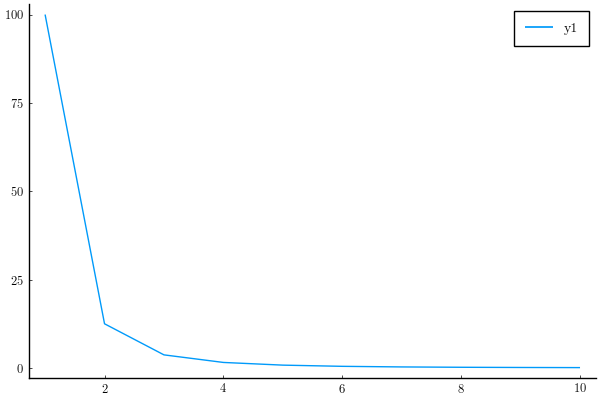

In [29]:
plot(ΛH)

In [30]:
σy = rand(Ny)
# Σy = Diagonal(σy^2*ones(Ny))
Σy = Diagonal(σy.^2)

ϵy = AdditiveInflation(Ny, zeros(Ny), Σy)

σx = 1.5*rand(Nx)
# Σx = Diagonal(σx^2*ones(Nx))
Σx = Diagonal(σx.^2)
ϵx = AdditiveInflation(Nx, zeros(Nx), Σx)

AdditiveInflation(50, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.0428413749438055 0.0 … 0.0 0.0; 0.0 0.05592295748431333 … 0.0 0.0; … ; 0.0 0.0 … 2.0941797781857754 0.0; 0.0 0.0 … 0.0 0.6912302913432447], [1.4292800197805207 0.0 … 0.0 0.0; 0.0 0.23648035327340267 … 0.0 0.0; … ; 0.0 0.0 … 1.4471281139504462 0.0; 0.0 0.0 … 0.0 0.8314026048451163])

In [31]:
H̃true = inv(ϵy.σ)*H*ϵx.σ
svdH̃true = svd(H̃true)

Cxtrue = H̃true'*H̃true
Cytrue = H̃true*H̃true'

eigen_Cxtrue = eigen(Symmetric(Cxtrue); sortby =  λ -> -λ)
eigen_Cytrue = eigen(Symmetric(Cytrue); sortby =  λ -> -λ)

Utrue = eigen_Cytrue.vectors[:,1:r]
Vtrue = eigen_Cxtrue.vectors[:,1:r]

# Norm of the different singular values
@show norm(svdH̃true.S-sqrt.(eigen_Cytrue.values))

# Distance between two subspaces (avoid the sign issue in the orientation of the normal vectors)
@show norm(Utrue*Utrue'-svdH̃true.U*svdH̃true.U')

# Distance between two subspaces (avoid the sign issue in the orientation of the normal vectors)
@show norm(Vtrue*Vtrue'-svdH̃true.V*svdH̃true.V');

norm(svdH̃true.S - sqrt.(eigen_Cytrue.values)) = 3.2041583361497906e-12
norm(Utrue * Utrue' - svdH̃true.U * (svdH̃true.U)') = 3.3943456119860134e-15
norm(Vtrue * Vtrue' - svdH̃true.V * (svdH̃true.V)') = 9.643985626634059e-11


In [32]:
K = ϵx.Σ*H'*inv(H*ϵx.Σ*H'+ϵy.Σ)

50×10 Array{Float64,2}:
  0.110562     -0.164113      0.165899     …  -0.163171     -0.103928
 -0.00350654    0.000347742   0.00801546       0.00180454   -2.55529e-5
 -0.0608323    -0.016563     -0.0374746        0.026178      0.0408334
 -0.0141735     0.0278605     0.0574421        0.028606      0.0646894
 -0.0126609    -0.0256197    -0.0313961        0.0185696    -0.0420176
 -0.00610683    0.0553953     0.092589     …   0.00774225    0.0611941
 -0.00125015    0.0338426    -0.0317568        0.00998945    0.0103451
 -1.06774e-5    5.30899e-5    0.000207998      8.36061e-5    3.70282e-5
  0.00892425    0.00451372    0.00273126      -0.00128442    0.000353782
  0.0253098    -0.0221059    -0.0071067       -0.00947649   -0.0462242
  0.0473236     0.0504655     0.0555227    …  -0.00637904    0.0146361
  0.0120492    -0.0453024     0.201229         0.0117742    -0.0351837
  0.0808435     0.0793629     0.0237759       -0.0236079     0.00956375
  ⋮                                        ⋱     

In [33]:
# Low-rank factorization based on the SVD decomposition of H̃

Klowrank = ϵx.σ*svdH̃true.V*Diagonal(svdH̃true.S ./(1.0 .+ svdH̃true.S.^2))*(svdH̃true.U'*inv(ϵy.σ))
@show norm(K - Klowrank);

norm(K - Klowrank) = 8.684156451560929e-13


In [35]:
# Low-rank factorization based on the eigen-decomposition of Cx and Cy

In [34]:
norm(Diagonal(svdH̃true.S ./(1.0 .+ svdH̃true.S.^2))-Diagonal(sqrt.(eigen_Cytrue.values[1:r])./(1.0 .+ sqrt.(eigen_Cytrue.values[1:r]).^2)))

3.067850002871926e-12

In [39]:
Klowranktrue = ϵx.σ*Vtrue*Diagonal(sqrt.(eigen_Cytrue.values[1:r])./(1.0 .+ sqrt.(eigen_Cytrue.values[1:r]).^2))*(Utrue'*inv(ϵy.σ))

50×10 Array{Float64,2}:
  0.0432544    -0.00512568  -0.471489     …  -0.0444112    -0.171136
 -0.00237289   -0.00125422  -0.00224076       0.00212511    0.00107913
 -0.0686193    -0.0193145   -0.0129348        0.0255462     0.0336162
 -0.0220467     0.0222506    0.0073628        0.0242671     0.0712082
 -0.0296325    -0.0657737    0.0241073       -0.0152156    -0.0245176
 -0.0361015     0.0413294   -0.0213489    …   0.00449535    0.0606097
  0.0143231     0.00867453   0.0622833       -0.0106101     0.0268429
  4.46979e-5   -1.40401e-5   0.000284546      5.63845e-5    7.48546e-5
  0.00175023    0.00510971  -0.00293095      -0.00288792   -0.000489861
  0.00952989   -0.0251673    0.00440252      -0.0144051    -0.0504851
  0.0170328     0.0446408   -0.0966312    …  -0.0244246     0.0402762
 -0.0340969    -0.0158086   -0.110079         0.0474827    -0.0583829
  0.0672071     0.0733271   -0.0548478       -0.0325574     0.0226197
  ⋮                                       ⋱                
 -0

In [36]:
A = randn(Ny, Nx)

eigen(A*A').vectors
reverse(svd(A).U, dims=2)

10×50 Array{Float64,2}:
  1.06708     1.80109   -0.0634413  …  -0.681461  -1.74231     1.27374
  0.698981   -0.337271   0.242886      -2.28341    0.632653   -0.538889
 -0.816773    0.982594  -1.06839        0.107479  -0.0331064   1.11867
 -0.778427    2.04222    0.0492614     -0.535027   2.57365     0.372095
 -1.05393    -0.242891   1.5238        -0.50829    2.07273     0.199643
  0.264069   -0.533339   0.190031   …   0.132607  -2.76674     0.792373
 -0.717689   -1.22367    0.412813      -0.875259  -1.26431    -0.185019
  0.857627   -0.658712   0.301038       1.3002    -0.377913   -0.70404
 -0.998053   -0.891262  -0.865664       0.953797   0.883542   -0.911261
 -0.0192155   1.41064   -0.300814       0.593893  -0.481735   -0.508074

In [37]:
@show norm((ϵx.σ*svdH̃true.V)-(ϵx.σ*Vtrue))
@show norm((ϵx.σ*svdH̃true.V)*(ϵx.σ*svdH̃true.V)'-(ϵx.σ*Vtrue)*(ϵx.σ*Vtrue)');

norm(ϵx.σ * svdH̃true.V - ϵx.σ * Vtrue) = 3.959619631216754
norm((ϵx.σ * svdH̃true.V) * (ϵx.σ * svdH̃true.V)' - (ϵx.σ * Vtrue) * (ϵx.σ * Vtrue)') = 1.0773584064215735e-10


In [38]:
@show norm(Utrue*Utrue'-svdH̃true.U*svdH̃true.U')

norm(Utrue * Utrue' - svdH̃true.U * (svdH̃true.U)') = 3.3943456119860134e-15


3.3943456119860134e-15

In [24]:
(svdH̃true.U'*inv(ϵy.σ))-(Utrue'*inv(ϵy.σ))

10×10 Array{Float64,2}:
 -0.181329     -6.16273      -2.13964      …   0.160334       5.15262
 -0.454387     -2.78985      -0.314222        -0.0863202    -13.3519
  6.66134e-16   8.41549e-14  -4.42146e-14      1.80411e-14   -4.41869e-14
 -6.7113e-14    2.77556e-14   1.01585e-13      2.15356e-13    1.4122e-13
 -4.12698e-13   2.37865e-12  -1.09113e-12      9.24955e-13   -9.08273e-13
  0.393111     -3.79447       2.45519      …  -0.179245       2.57496
 -0.863087     -2.32208       1.3609           0.0697346      0.516696
 -0.739185     -1.19916       0.288962        -0.211502      -0.0292836
  9.35104e-11  -1.23105e-11  -4.51666e-11     -1.52978e-10   -1.80581e-11
 -0.841188      0.274813      0.363906         1.47731        0.13291

In [54]:
svdH̃true.U'

10×10 Adjoint{Float64,Array{Float64,2}}:
 -0.270075     0.00212971  -0.291549    …   0.173026    0.0498276  -0.0473677
  0.153106    -0.0230826    0.208771       -0.117459   -0.0436095  -0.0439794
  0.541312    -0.663984    -0.0351566      -0.18727    -0.346121   -0.10812
 -0.153507     0.372224     0.00821959     -0.271892   -0.4556     -0.30602
 -0.010279    -0.0697961   -0.331943        0.151071    0.341128   -0.306359
  0.515239     0.252764     0.358919    …   0.0195961   0.57687    -0.0233832
  0.00749811   0.240835     0.521101       -0.0270186  -0.20835    -0.430583
  0.403279     0.256129    -0.47438         0.231429   -0.0747738  -0.526372
  0.189634     0.120297     0.142667        0.797094   -0.385534    0.298361
 -0.350438    -0.461737     0.337883        0.366627    0.146491   -0.494563

In [57]:
(svdH̃true.U'*inv(ϵy.σ))*(svdH̃true.U'*inv(ϵy.σ))'

10×10 Array{Float64,2}:
 52.2082     78.1374    -3.27521    …   2.2845     -0.227841   -3.31756
 78.1374    130.666     -5.41868        5.02398     0.351154   -5.861
 -3.27521    -5.41868    3.66505        0.0789634   0.535553   -0.148695
 -5.9323    -10.3157     0.282461      -1.05408     0.610401    0.665287
 -7.05253   -10.0651     0.449268      -1.34883     0.309121    0.0835426
 -0.837298   -1.955      0.976032   …   0.426017    0.259225   -0.405138
 -2.65103    -5.04539    0.119655      -0.173267    0.0380786  -0.619891
  2.2845      5.02398    0.0789634      2.72477     0.0774641  -0.840009
 -0.227841    0.351154   0.535553       0.0774641   1.70498    -0.405768
 -3.31756    -5.861     -0.148695      -0.840009   -0.405768    2.62864

In [61]:
(Utrue'*inv(ϵy.σ))*(Utrue'*inv(ϵy.σ))'-(svdH̃true.U'*inv(ϵy.σ))*(svdH̃true.U'*inv(ϵy.σ))'

10×10 Array{Float64,2}:
   -4.9738e-14   -156.275         6.55043      …   0.455681      8.02824e-12
 -156.275          -2.84217e-14  -1.04805e-13      1.1479e-10   11.722
    6.55043        -1.04805e-13   4.13003e-14      1.03628e-12   0.29739
   11.8646         -3.06777e-12   3.99847e-13     -1.98284e-11  -1.33057
   -1.28164e-12    20.1301       -0.898537        -0.618242     -5.70724e-13
   -7.54086e-12     3.91001      -1.95206      …  -0.51845       3.82416e-12
   -1.34985e-11    10.0908       -0.239311        -0.0761571     4.78084e-12
   -9.76019e-12   -10.048        -0.157927        -0.154928      2.55718e-12
    0.455681        1.1479e-10    1.03628e-12      8.61022e-12   0.811536
    8.02824e-12    11.722         0.29739          0.811536     -8.52385e-12

In [41]:
norm((svdH̃true.U'*inv(ϵy.σ))*(svdH̃true.U'*inv(ϵy.σ))'-(Utrue'*inv(ϵy.σ))*(Utrue'*inv(ϵy.σ))')

225.32225826114157

In [11]:
H̃sample2 = inv(ϵy.σ)*H*Diagonal(std(state(X, Ny, Nx); dims = 2)[:,1])

10×50 Array{Float64,2}:
    99.3631   -12.7213     …    60.2861    -39.1814    -12.2703
     7.93658   -2.46656          1.1374     -0.537112   -1.677
   -23.6786     6.35603         -9.34257     3.54967     4.78541
    -7.53375    1.92682         -5.70411    -0.519312    1.59586
    -1.13667    0.375754         0.111341    0.878473    0.314371
 -1374.35     373.085      …  -643.522     -17.7255    290.839
     2.3822    -1.08667          0.754411    0.357702   -0.516989
    -8.01661    2.59341         -5.0484     -2.20263     2.19771
     1.03511    0.0243595        6.36536     1.01069    -0.448791
     8.04708   -2.53818          3.71168    -0.641853   -1.83559

In [12]:
H̃sample3 = Ly\H*Lx'

10×50 Array{Float64,2}:
    99.3631   -14.6252      …    73.3993    -31.4589    -18.5704
     7.93658   -2.61696           2.70649    -2.86358    -2.27889
   -23.6786     6.80591         -13.6738      7.68572     6.64539
    -7.53375    2.07007          -7.1218      0.246211    2.31439
    -1.13667    0.397269         -0.117376    1.55309     0.329184
 -1374.35     399.192       …  -907.311     237.375     403.835
     2.3822    -1.13142           1.3766     -0.929166   -0.751205
    -8.01661    2.74522          -6.80706     0.208244    3.06853
     1.03511    0.00434576        6.68148     0.726126   -0.876173
     8.04708   -2.69064           5.42771    -3.02879    -2.54526

1.731585933227756e-10

3.3405486944205636e-15

4.688369679560653e-9

In [14]:
@show norm(H̃sample1-H̃true)/norm(H̃true)
@show norm(H̃sample2-H̃true)/norm(H̃true)
@show norm(H̃sample3-H̃true)/norm(H̃true)

norm(H̃sample1 - H̃true) / norm(H̃true) = 0.09963670564138055
norm(H̃sample2 - H̃true) / norm(H̃true) = 0.023981153500155054
norm(H̃sample3 - H̃true) / norm(H̃true) = 0.22425599336111054


0.22425599336111054

In [15]:
H̃sample = copy(H̃sample2);

In [8]:
X = zeros(Ny+Nx, Ne)

# Samples from the standard normal distribution
ϵx(X, Ny+1, Ny+Nx)

# Compute observations
observe((x, t)->H*x, X, 0.0, Ny, Nx)

ϵ = ϵy.m .+ ϵy.σ*randn(Ny, Ne)

10×1000 Array{Float64,2}:
  0.00699578   0.0146034    0.0259124   …  -0.0139011    0.00743032
 -0.383682    -0.435725    -0.400231        0.384293     0.171247
 -0.689799    -0.284794    -0.391664       -0.636691    -0.15418
 -0.952706     0.852645     0.758234        0.491606     0.0539494
  0.593847     0.0211247   -0.171221        0.322397    -0.556929
 -0.00300094  -0.00518389  -0.00731005  …   0.00359752  -0.00036895
  0.702174     1.48297     -1.95138        -0.340593     0.220993
 -0.206909     0.112897     0.222522        0.284651    -0.129815
 -0.538942     0.11232     -0.289009       -0.566614     0.252524
  0.414876     0.548523    -0.712705       -0.803153    -0.0715659

In [9]:
Σxx = Symmetric(cov(state(X, Ny, Nx)'))
Σxy = 1/(Ne-1)*(state(X, Ny, Nx) .- mean(state(X,Ny,Nx);dims = 2)[:,1])*(meas(X, Ny, Nx) .- mean(meas(X,Ny,Nx);dims = 2)[:,1])'
Σyy = Symmetric(cov(meas(X, Ny, Nx)'))

Lx = cholesky(Σxx).L
Ly = cholesky(ϵy.Σ).L

H̃sample1 = inv(ϵy.σ)*H*Σxx^(0.5)

10×50 Array{Float64,2}:
   109.973    -14.6025      0.974262   …  -37.8582      -16.5132
     8.79487   -2.66804     0.331044       -1.25776      -1.90002
   -26.4843     6.81203    -0.854296        4.84427       5.64917
    -8.44327    2.07732    -0.304106       -0.294925      1.99496
    -1.24346    0.44683    -0.0306883       1.07871       0.293187
 -1530.77     399.827     -55.2352     …   59.0051      344.738
     2.74824   -1.11953     0.16362         0.00443871   -0.588995
    -9.03258    2.80341    -0.50678        -1.55809       2.60135
     1.66574    0.089517    0.223646        1.0038       -0.711755
     9.09207   -2.67045     0.402201       -1.33509      -2.12663

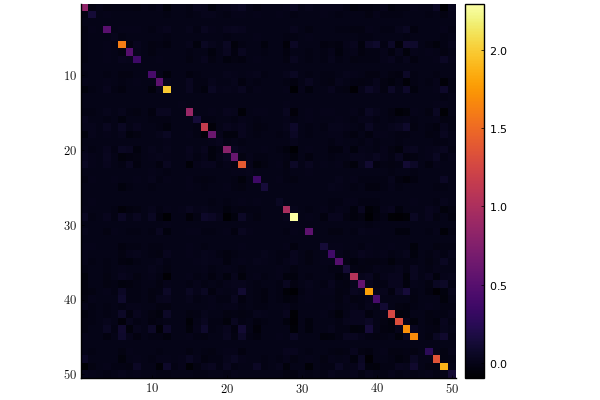

In [10]:
heatmap(Σxx, ratio = 1, yflip = true)

50×10 Array{Float64,2}:
  0.106722      0.0481423    -0.039728     …  -0.00322272   -0.0772751
 -0.0454708    -0.0109886    -0.0178997       -0.0263239     0.0369406
  0.000200011   0.000281841   0.000239712      6.34704e-5    0.000527645
  0.0987104    -0.080148      0.0103476        0.00213065   -0.0284579
 -0.00908165    0.000664757  -0.00231012       0.000531325  -0.00442745
 -0.100097      0.0513338     0.0549759    …  -0.157222      0.15645
 -0.39228      -0.0531476    -0.14399         -0.0464773     0.0445487
 -0.0492319    -0.02259      -0.0214197        0.0183765    -0.105364
  0.000251928   7.78667e-5    0.00015099       0.000210914   2.26222e-5
 -0.165828     -0.0299445    -0.0189638       -0.0168237    -0.0237333
  0.188535      0.103036      0.0581315    …   0.097885     -0.0517067
  0.135702     -0.28216      -0.113734        -0.0661167     0.26076
  0.00099108   -4.08251e-5    0.000109321     -0.000179751  -0.000582471
  ⋮                                        ⋱        

In [25]:
norm(Kr-Ktrue)/norm(Ktrue)

1.7116095089954881

In [26]:
K = Σxx*H'*inv(Σyy)

50×10 Array{Float64,2}:
  0.164901      0.198444      0.205342     …   0.11925      -0.122846
  0.0881053    -0.00247491    0.0299321        0.0253659     0.0396416
  0.000638444  -0.00031144   -0.00087318      -6.18636e-5   -0.000594791
 -0.3498       -0.0509595    -0.120614        -0.0309927    -0.0292251
 -0.0187914    -0.00670659   -0.00321863      -3.98007e-5   -0.00477008
  0.457568      0.00780875    0.0425365    …   0.20071      -0.113818
  0.279222     -0.0885642     0.122363         0.0317229     0.0504021
 -0.0508078    -0.0234094    -0.0298705        0.0163247    -0.184605
 -0.00373285    0.000421861  -0.00085783      -0.000816419   0.00316881
 -0.0298667    -0.0586012    -0.0724674        0.00707818   -0.112147
 -0.053338      0.00763285   -0.00441486   …  -0.113086      0.177778
 -0.428814     -0.10595       0.0369477       -0.0922181     0.68358
 -0.00014098    0.000120767   0.000169838     -3.26505e-5    0.00308521
  ⋮                                        ⋱           

In [27]:
svdH̃sample = svd(H̃sample);

In [28]:
svdH̃sample

SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
 -0.0858432     0.993434     0.0424005   …   0.0183841   -0.00869057
 -0.00427992   -0.0417124    0.376053        0.137864    -0.0325499
  0.0165554     0.00779214  -0.454378        0.311784    -0.104332
  0.00655508   -0.0281695    0.292114        0.753991    -0.254495
  0.000198579   0.0182939   -0.18724        -0.405636    -0.388128
  0.9961        0.0851379    0.00860412  …  -0.00838968  -0.000904592
 -0.00122033   -0.0300083    0.0994275      -0.154182     0.606655
  0.00645936    0.0251473    0.20109        -0.100294     0.175685
 -0.00296151    0.0125373   -0.673694        0.18674      0.0461553
 -0.00529989   -0.0349528    0.16024        -0.285712    -0.609542
singular values:
10-element Array{Float64,1}:
 7636.189606706128
  285.22570048788043
   13.716753824049382
    9.358266215974478
    3.8721822433388464
    2.2757836903283017
    1.6865070585107815
    1.3889376317580147
    1.1380090385414796
    1.

In [29]:
Klowrank = Σx^(1/2)*V*Diagonal(Λ)*inv(Diagonal(Λ).^2 + I)*U'*Σy^(-1/2)

LoadError: [91mUndefVarError: Λ not defined[39m

In [201]:
isposdef(Symmetric(Σxy*inv(Σyy)*(Σxy')))

false

In [205]:
E1 = eigen(Symmetric(Σxy*(Σyy\(Σxy'))), Σxx)

GeneralizedEigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
20-element Array{Float64,1}:
 -3.736850343961709e-16
 -3.0305094340771137e-16
 -1.923381154300831e-16
 -1.4238510144807033e-16
 -9.300044222400317e-17
  3.4479841235178085e-17
  1.3410353537158534e-16
  2.1078159296229402e-16
  2.995416215529736e-16
  4.689211302293456e-16
  0.9570211827183169
  0.9659209804444706
  0.9686105857075465
  0.9726839687208598
  0.9789657439959808
  0.9814310543103316
  0.9887800893351203
  0.9926040586080717
  0.9961585552968009
  0.9992011445399831
vectors:
20×20 Array{Float64,2}:
 -0.0751051    0.244383    -0.00443213  …   0.157721     0.212473
  0.146489    -0.0226617   -0.239765       -0.0932904   -0.163616
 -0.110238    -0.00996158  -0.0130902      -0.575474     0.0639061
  0.140373     0.143651    -0.101987       -0.135806    -0.00815613
 -0.120679    -0.00663185  -0.0888664      -0.085245     0.0399172
 -0.0192349    0.0272652    0.233491    …  -0.0845982   -0.141855
  0.115

In [215]:
Λ = E1.values./(1.0 .-E1.values)

20-element Array{Float64,1}:
   -3.7368503439617073e-16
   -3.030509434077113e-16
   -1.9233811543008305e-16
   -1.423851014480703e-16
   -9.300044222400317e-17
    3.4479841235178085e-17
    1.3410353537158537e-16
    2.1078159296229407e-16
    2.995416215529737e-16
    4.689211302293458e-16
   22.26727591050266
   28.343567187153656
   30.857873825967403
   35.60853913151168
   46.54149611038874
   52.85335369667177
   88.1272693578725
  134.20929209787457
  259.31872830740076
 1250.7909059278932

In [76]:
svd(H̃)

SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
  0.0641204   0.254384    -0.183958  -0.428634   …  -0.573138    0.606823
 -0.290928    0.00401832  -0.529376  -0.0533508      0.0616348  -0.0551907
  0.266514    0.276454    -0.324761  -0.146112      -0.0318523  -0.422608
 -0.101319   -0.734992    -0.286928  -0.440352       0.194789    0.106851
 -0.464208    0.0949348    0.396239  -0.50769       -0.26221    -0.407861
  0.438384    0.0578712   -0.291812  -0.322354   …   0.0604909  -0.322774
 -0.160714    0.42229     -0.342238   0.0710781      0.183573    0.0647777
 -0.163705   -0.264538    -0.300814   0.473722      -0.527065   -0.0847683
 -0.0957332  -0.104994    -0.11734    0.0826278     -0.41496    -0.394481
  0.600409   -0.216651     0.185956   0.0146778     -0.269546   -0.0342671
singular values:
10-element Array{Float64,1}:
 1.0126563692273145
 1.0094742386434066
 1.0045156753655875
 1.0022953349083663
 0.9952130408768515
 0.9872278249739405
 0.984362710333514

In [21]:
Σyy = 

α = 1.0
λ0 = 500
τ = 1e-9

λtilde0 = 1.0
τtilde = 1e-9
ΛH = map(i-> λ0/(i^α) + τ, 1:min(Ny, Nx))
ΛX = map(i-> λtilde0/(i^α) + τtilde, 1:Nx)

20-element Array{Float64,1}:
 1.000000001
 0.500000001
 0.33333333433333334
 0.250000001
 0.200000001
 0.16666666766666666
 0.14285714385714285
 0.125000001
 0.1111111121111111
 0.100000001
 0.09090909190909091
 0.08333333433333333
 0.07692307792307693
 0.07142857242857142
 0.06666666766666667
 0.062500001
 0.058823530411764705
 0.05555555655555555
 0.05263157994736842
 0.050000001

In [25]:
U = Matrix(qr(randn(Ny, Ny)).Q)
V = Matrix(qr(randn(Ny, Ny)).Q)

20×20 Array{Float64,2}:
 -0.385419    0.279758   -0.116839    -0.062175   …   0.298618    0.188885
  0.0924087  -0.41927    -0.104403    -0.0991016     -0.190351   -0.100921
 -0.248725   -0.0647208  -0.0435458   -0.16483       -0.227559    0.21432
  0.360298   -0.107573    0.158463    -0.234489       0.103325    0.274374
  0.39222    -0.115525    0.150809    -0.0752712      0.135093   -0.0973899
  0.0672663  -0.082833    0.015547    -0.448899   …   0.120159    0.1809
 -0.03138     0.301628   -0.421907    -0.168517      -0.11352    -0.195903
  0.149903    0.103326    0.0255276    0.185168       0.146221    0.377058
 -0.13661    -0.0478563   0.193874    -0.0736007     -0.0737505   0.0600682
 -0.238123    0.0563366   0.0455886    0.0367086     -0.19281    -0.00233535
 -0.030822   -0.163139   -0.390238     0.142061   …  -0.032612   -0.428519
 -0.0898115  -0.152397    0.175962    -0.0161426      0.564832   -0.116649
 -0.0629619  -0.22733    -0.177667    -0.453958       0.119715   -0.228413


In [ ]:
H = rand(Ny, Nx)

σy = 0.1
Σy = Diagonal(σy^2*ones(Ny))
ϵy = AdditiveInflation(zeros(Ny), σy)

σx = 1.5
Σx = Diagonal(σx^2*ones(Nx))
L = cholesky(inv(Σx))
ϵx = AdditiveInflation(zeros(Nx), σx)

LoadError: [91mUndefVarError: X not defined[39m

LoadError: [91mUndefVarError: Ne not defined[39m

In [6]:
Σyy = copy(Σy);

LoadError: [91mUndefVarError: Σy not defined[39m

In [7]:
@time Σy\(Σxy')

LoadError: [91mUndefVarError: Σxy not defined[39m

In [164]:
@time Σxy*(Σy\(Σxy'));

  0.000021 seconds (3 allocations: 4.141 KiB)


In [162]:
eigen(Hermitian(Σxx - Σxy*inv(Σy)*Σxy'));

In [161]:
E1 = eigen(Σxx, Σxx - Σxy*inv(Σy)*Σxy');

In [150]:
Λ1 = zeros(min(Nx,Ny))

for i in axes(Λ,1)
    @show E1.values[end-i+1]
    Λ1[i] = E1.values[end-i+1]/(1-E1.values[end-i+1])
end

E1.values[(end - i) + 1] = 5533.683492171553
E1.values[(end - i) + 1] = 768.4434872518958
E1.values[(end - i) + 1] = 358.5800517087799
E1.values[(end - i) + 1] = 187.10343240248906
E1.values[(end - i) + 1] = 137.52803671519075


In [84]:
X = zeros(Ny+Nx, Ne)
ϵx(X, Ny+1, Ny+Nx)

In [85]:
xstar = σx*randn(Nx)
ystar = H*xstar

5-element Array{Float64,1}:
  3.1863782281677557
  1.2961341870904126
  0.6382307854274372
  2.243377328071246
 -1.0139311553757233

In [86]:
X

25×500 Array{Float64,2}:
  0.0         0.0        0.0        …   0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
 -1.2458     -1.33112   -1.64702    …   3.36754   -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998   -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933   2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269  -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634   0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167  -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673    0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324  -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       -0.333976  -1.61289     0.99464

In [87]:
# Compute observations
observe((x, t)->H*x, X, 0.0, Ny, Nx)

In [88]:
H*X[Ny+1:Ny+Nx,1]

5-element Array{Float64,1}:
 -4.201837580911975
 -2.1394534272246384
 -4.019694321430913
 -3.075109147097886
 -4.203807085694468

In [89]:
# Perturb observations
ϵy(X, 1, Ny)

In [90]:
H̃ = Σy^(-1/2)*H*Σx^(1/2)

5×20 Array{Float64,2}:
 13.2246   12.1639    8.33884  12.5696   …  0.33596   13.0077     6.104
 11.7709    4.02518   4.32466  12.2453      3.82649    4.51892    0.736347
 14.3812    7.6828   12.7421   14.2567      0.309371   0.571132   5.6817
 12.7464    1.10851   2.9518   12.5377      2.96307    9.68206   14.5612
  9.11181   3.50321   1.7109    3.99807     3.86428    9.44018    6.83744

In [91]:
svdH̃ = svd(H̃)
r = Ny
Λ = svdH̃.S[1:r]
U = svdH̃.U[:,1:r]
V = Matrix(svdH̃.Vt')[:,1:r]

norm(U*Diagonal(Λ)*V'-H̃)

6.670033592382955e-14

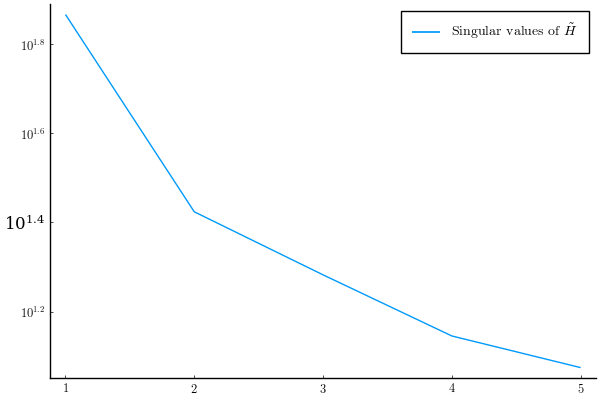

In [92]:
plot(Λ, yscale = :log10, label = L"Singular values of $\tilde{H}$")

In [93]:
Σy

5×5 Diagonal{Float64,Array{Float64,1}}:
 0.01   ⋅     ⋅     ⋅     ⋅ 
  ⋅    0.01   ⋅     ⋅     ⋅ 
  ⋅     ⋅    0.01   ⋅     ⋅ 
  ⋅     ⋅     ⋅    0.01   ⋅ 
  ⋅     ⋅     ⋅     ⋅    0.01

In [94]:
X

25×500 Array{Float64,2}:
 -4.13629    -0.831244   0.717565   …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904    1.03149       -0.0446603  -2.30553     2.6002
 -4.08742     0.606595   0.793833      -1.4667      0.910888    3.49455
 -3.03034    -1.86637    0.992155       1.39849     0.262881    1.31985
 -4.09688    -2.23186    0.409984       0.218713   -1.91686     1.1933
 -1.2458     -1.33112   -1.64702    …   3.36754    -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998    -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933    2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269   -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634    0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167   -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673     0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324   -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       

In [95]:
X̃ = copy(X)

25×500 Array{Float64,2}:
 -4.13629    -0.831244   0.717565   …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904    1.03149       -0.0446603  -2.30553     2.6002
 -4.08742     0.606595   0.793833      -1.4667      0.910888    3.49455
 -3.03034    -1.86637    0.992155       1.39849     0.262881    1.31985
 -4.09688    -2.23186    0.409984       0.218713   -1.91686     1.1933
 -1.2458     -1.33112   -1.64702    …   3.36754    -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998    -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933    2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269   -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634    0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167   -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673     0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324   -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       

In [96]:
view(X̃,1:Ny, :) .= Σy^(-1/2)*view(X, 1:Ny, :)

5×500 view(::Array{Float64,2}, 1:5, :) with eltype Float64:
 -41.3629   -8.31244   7.17565  -79.8323   …   -3.2971    -18.3319   42.1481
 -21.8269  -13.1904   10.3149     5.98496      -0.446603  -23.0553   26.002
 -40.8742    6.06595   7.93833  -65.0499      -14.667       9.10888  34.9455
 -30.3034  -18.6637    9.92155  -30.393        13.9849      2.62881  13.1985
 -40.9688  -22.3186    4.09984  -15.8272        2.18713   -19.1686   11.933

In [97]:
@time view(X̃,Ny+1:Ny+Nx, :) .= Σx^(-1/2)*view(X, Ny+1:Ny+Nx, :)

  0.000150 seconds (17 allocations: 78.922 KiB)


20×500 view(::Array{Float64,2}, 6:25, :) with eltype Float64:
 -0.830531   -0.887413  -1.09801    …   2.24502    -0.0385918   0.70321
 -1.52463     2.17562   -0.271358      -1.04665    -0.421929    0.622044
 -0.469627    2.47093   -1.06895       -0.0992884   1.9379      1.90871
 -0.0423554   0.525269   1.01961       -0.442179   -0.106734   -0.593515
 -0.489888   -0.869489  -0.237863      -0.573089    0.149428    0.860822
  0.836328   -0.625207  -0.69303    …  -0.411445   -1.3325      0.0822692
  0.258944   -0.601023  -1.70955        0.931155    0.397813    1.67433
  0.443987   -1.00311    1.34579       -0.545549   -0.66273    -0.859249
  0.691504   -0.446074  -0.820293      -0.222651   -1.07526     0.663096
 -0.68108    -0.465749   0.582494       1.28106     0.118654    1.88932
 -0.666418    0.494957   1.34751    …   0.154679   -1.2969     -0.837
 -1.95927    -0.985845   0.945772       0.850864   -0.0961618  -1.23269
  0.617864   -0.557774   0.36103       -1.99929     0.964902    1.312

In [98]:
mean(X̃; dims = 2)

25×1 Array{Float64,2}:
 -0.7823400688534918
 -1.6111181975140163
  0.1681611995322183
 -2.6036276784051893
 -2.262391214861934
  0.05670419576942602
  0.05145452693243453
  0.008355510272549278
 -0.01691546809605259
  0.02231291052328124
  0.07277969298086735
  0.035829804521281886
  0.011367217784992296
  0.025756768601362116
 -0.043646282130600136
 -0.059677091191211146
 -0.05563785099735409
 -0.04510014532669326
 -0.010456416776879716
 -0.03674417550200221
 -0.03724606038167628
 -0.04711627894955761
 -0.015217172265051536
 -0.04170016287513491
 -0.07923653502070366

In [99]:
H̃ - Σy^(-1/2)*H*Σx^(1/2)

5×20 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

20×5 Array{Float64,2}:
 -0.149439     0.145923     0.158918     0.197409     -0.12959
  0.345397    -0.00452612  -0.0316272   -0.392728      0.0770016
 -0.00200294   0.0671384    0.209074    -0.0914481    -0.0915309
 -0.191262     0.341819     0.170131     0.319211     -0.425661
  0.0385124   -0.310455    -0.0251588   -0.0297553     0.389881
  0.223667    -0.26863     -0.0313412   -0.104689      0.194512
  0.0246272    0.238984    -0.0581879   -0.144172      0.0465056
  0.0331696    0.0538537    0.157497    -0.0113525    -0.12959
  0.188242    -0.148307     0.192718    -0.353031      0.164898
  0.191805    -0.0945659   -0.180594     0.272121     -0.194787
 -0.0625104    0.257766    -0.0518823   -0.148945      0.177464
  0.156351    -0.149314    -0.0673382   -0.000561701   0.152606
  0.0137476    0.12555     -0.0322645    0.0511158     0.00630486
  0.327596     0.264226    -0.236392    -0.09597      -0.28114
 -0.197927    -0.251453     0.344922    -0.0535286     0.287324
  0.0542617    

In [101]:
K = Σx*H'*inv(H*Σx*H'+Σy)

20×5 Array{Float64,2}:
 -0.149439     0.145923     0.158918     0.197409     -0.12959
  0.345397    -0.00452612  -0.0316272   -0.392728      0.0770016
 -0.00200294   0.0671384    0.209074    -0.0914481    -0.0915309
 -0.191262     0.341819     0.170131     0.319211     -0.425661
  0.0385124   -0.310455    -0.0251588   -0.0297553     0.389881
  0.223667    -0.26863     -0.0313412   -0.104689      0.194512
  0.0246272    0.238984    -0.0581879   -0.144172      0.0465056
  0.0331696    0.0538537    0.157497    -0.0113525    -0.12959
  0.188242    -0.148307     0.192718    -0.353031      0.164898
  0.191805    -0.0945659   -0.180594     0.272121     -0.194787
 -0.0625104    0.257766    -0.0518823   -0.148945      0.177464
  0.156351    -0.149314    -0.0673382   -0.000561701   0.152606
  0.0137476    0.12555     -0.0322645    0.0511158     0.00630486
  0.327596     0.264226    -0.236392    -0.09597      -0.28114
 -0.197927    -0.251453     0.344922    -0.0535286     0.287324
  0.0542617    

In [102]:
norm(Klowrank-K)

3.9330182325197666e-15

In [103]:
Xpost = deepcopy(X)

25×500 Array{Float64,2}:
 -4.13629    -0.831244   0.717565   …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904    1.03149       -0.0446603  -2.30553     2.6002
 -4.08742     0.606595   0.793833      -1.4667      0.910888    3.49455
 -3.03034    -1.86637    0.992155       1.39849     0.262881    1.31985
 -4.09688    -2.23186    0.409984       0.218713   -1.91686     1.1933
 -1.2458     -1.33112   -1.64702    …   3.36754    -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998    -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933    2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269   -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634    0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167   -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673     0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324   -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       

In [104]:
view(Xpost, Ny+1:Ny+Nx, :) .= view(X,Ny+1:Ny+Nx,:) - Klowrank*(view(X,1:Ny,:) .- ystar)

20×500 view(::Array{Float64,2}, 6:25, :) with eltype Float64:
 -0.439896   -0.891394   -1.57054   …   3.69879    -0.0518124   1.03264
 -1.75667     3.11804    -0.151626     -0.8549      0.384906    0.141436
 -0.261992    3.39323    -1.60722       0.409692    2.81784     2.29796
  0.900168    1.71224     2.12672       0.275049    0.312433   -0.390946
 -0.606666   -1.60964    -0.932347     -1.69916    -0.40073     0.840302
  1.85727    -0.936055   -0.961526  …  -0.585099   -1.86671    -0.192806
  0.508214   -0.715317   -2.67784       1.50214     1.3534      2.10493
  1.3811     -1.43008     2.26064      -0.147821   -0.816072   -1.56753
  1.45706    -1.54461    -1.51146       0.0331741  -1.80498    -0.246014
  0.0350743   0.70007     1.96819       2.55908     1.21246     3.95713
 -1.04421     0.767764    1.50418   …  -0.0959642  -1.45133    -1.90842
 -2.16414    -1.05967     1.55762       1.29551     0.257831   -1.96013
  1.60077    -0.236363    0.668712     -2.81476     2.08427     1.916

In [105]:
Xpost

25×500 Array{Float64,2}:
 -4.13629    -0.831244    0.717565  …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904     1.03149      -0.0446603  -2.30553     2.6002
 -4.08742     0.606595    0.793833     -1.4667      0.910888    3.49455
 -3.03034    -1.86637     0.992155      1.39849     0.262881    1.31985
 -4.09688    -2.23186     0.409984      0.218713   -1.91686     1.1933
 -0.439896   -0.891394   -1.57054   …   3.69879    -0.0518124   1.03264
 -1.75667     3.11804    -0.151626     -0.8549      0.384906    0.141436
 -0.261992    3.39323    -1.60722       0.409692    2.81784     2.29796
  0.900168    1.71224     2.12672       0.275049    0.312433   -0.390946
 -0.606666   -1.60964    -0.932347     -1.69916    -0.40073     0.840302
  1.85727    -0.936055   -0.961526  …  -0.585099   -1.86671    -0.192806
  0.508214   -0.715317   -2.67784       1.50214     1.3534      2.10493
  1.3811     -1.43008     2.26064      -0.147821   -0.816072   -1.56753
  1.45706    -1.54461    -1.51146    